In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
df = pl.read_parquet("transaction_fraud_data.parquet")

In [47]:
df.head()

transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
str,str,i64,datetime[μs],str,str,str,f64,str,str,str,str,str,bool,str,str,str,str,bool,bool,bool,struct[5],bool
"""TX_a0ad2a2a""","""CUST_72886""",6646734767813109,2024-09-30 00:00:01.034820,"""Restaurant""","""fast_food""","""Taco Bell""",294.87,"""GBP""","""UK""","""Unknown City""","""medium""","""Platinum Credit""",false,"""iOS App""","""mobile""","""e8e6160445c935fd0001501e4cbac8…","""197.153.60.199""",false,false,false,"{1197,3.3499e7,105,12,1.9255e6}",false
"""TX_3599c101""","""CUST_70474""",376800864692727,2024-09-30 00:00:01.764464,"""Entertainment""","""gaming""","""Steam""",3368.97,"""BRL""","""Brazil""","""Unknown City""","""medium""","""Platinum Credit""",false,"""Edge""","""web""","""a73043a57091e775af37f252b3a32a…","""208.123.221.203""",true,true,false,"{509,2.0115e7,100,12,5.1491e6}",true
"""TX_a9461c6d""","""CUST_10715""",5251909460951913,2024-09-30 00:00:02.273762,"""Grocery""","""physical""","""Whole Foods""",102582.38,"""JPY""","""Japan""","""Unknown City""","""medium""","""Platinum Credit""",false,"""Firefox""","""web""","""218864e94ceaa41577d216b1497222…","""10.194.159.204""",false,false,false,"{332,3.9164e7,97,12,1.8522e6}",false
"""TX_7be21fc4""","""CUST_16193""",376079286931183,2024-09-30 00:00:02.297466,"""Gas""","""major""","""Exxon""",630.6,"""AUD""","""Australia""","""Unknown City""","""medium""","""Premium Debit""",false,"""iOS App""","""mobile""","""70423fa3a1e74d01203cf93b51b963…","""17.230.177.225""",false,false,false,"{764,2.2013e7,105,12,2.0558e6}",false
"""TX_150f490b""","""CUST_87572""",6172948052178810,2024-09-30 00:00:02.544063,"""Healthcare""","""medical""","""Medical Center""",724949.27,"""NGN""","""Nigeria""","""Unknown City""","""medium""","""Basic Debit""",false,"""Chrome""","""web""","""9880776c7b6038f2af86bd4e18a1b1…","""136.241.219.151""",true,false,false,"{218,4.8276e6,88,12,1.1572e6}",true


# Гипотеза 1: айфоны

In [10]:
# фильтрация high-risk транзакций
high_risk_df = df.filter(
    pl.col("is_high_risk_vendor") & (pl.col("device").is_not_null())
)

In [20]:
fraud_rates_by_device = (
    high_risk_df
    .with_columns([
        pl.when(pl.col("device") == "iOS App")
          .then("device")
          .otherwise(pl.lit("Other"))
          .alias("device_group")
    ])
    .group_by("device_group")
    .agg([
        pl.len().alias("total"),
        pl.col("is_fraud").sum().alias("frauds")
    ])
    .with_columns([
        (pl.col("frauds") / pl.col("total")).alias("fraud_rate")
    ])
)


fraud_rates_by_device


device_group,total,frauds,fraud_rate
str,u32,u32,f64
"""iOS App""",285759,35090,0.122796
"""Other""",1586204,339277,0.213892


# Гипотеза 2: выходные, страны...

In [41]:

weekend_offline_df = (
    df.filter(
        (pl.col("last_hour_activity").is_not_null())
    )
    .select([
        "is_weekend",
        "is_fraud",
        pl.col("last_hour_activity").struct.field("num_transactions").alias("activity")
    ])
)


In [42]:
# биннинг активности по группам
weekend_offline_df = weekend_offline_df.with_columns(
    pl.when(pl.col("activity") < 2).then(pl.lit("Low"))
    .when(pl.col("activity") < 5).then(pl.lit("Medium"))
    .otherwise(pl.lit("High")).alias("activity_level")
)


In [44]:
#fraud rate по выходным/невыходным и уровню активности
import plotly.express as px
agg_df = (
    weekend_offline_df
    .group_by(["is_weekend", "activity_level"])
    .agg([
        pl.len().alias("total"),
        pl.col("is_fraud").sum().alias("frauds")
    ])
    .with_columns([
        (pl.col("frauds") / pl.col("total")).alias("fraud_rate")
    ])
    .to_pandas()
)

fig = px.bar(
    agg_df,
    x="activity_level",
    y="fraud_rate",
    color="is_weekend",
    barmode="group",
    title="Fraud Rate by Activity Level & Weekend"
)
fig.show()


/tmp/ipykernel_381129/2008333047.py:6: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



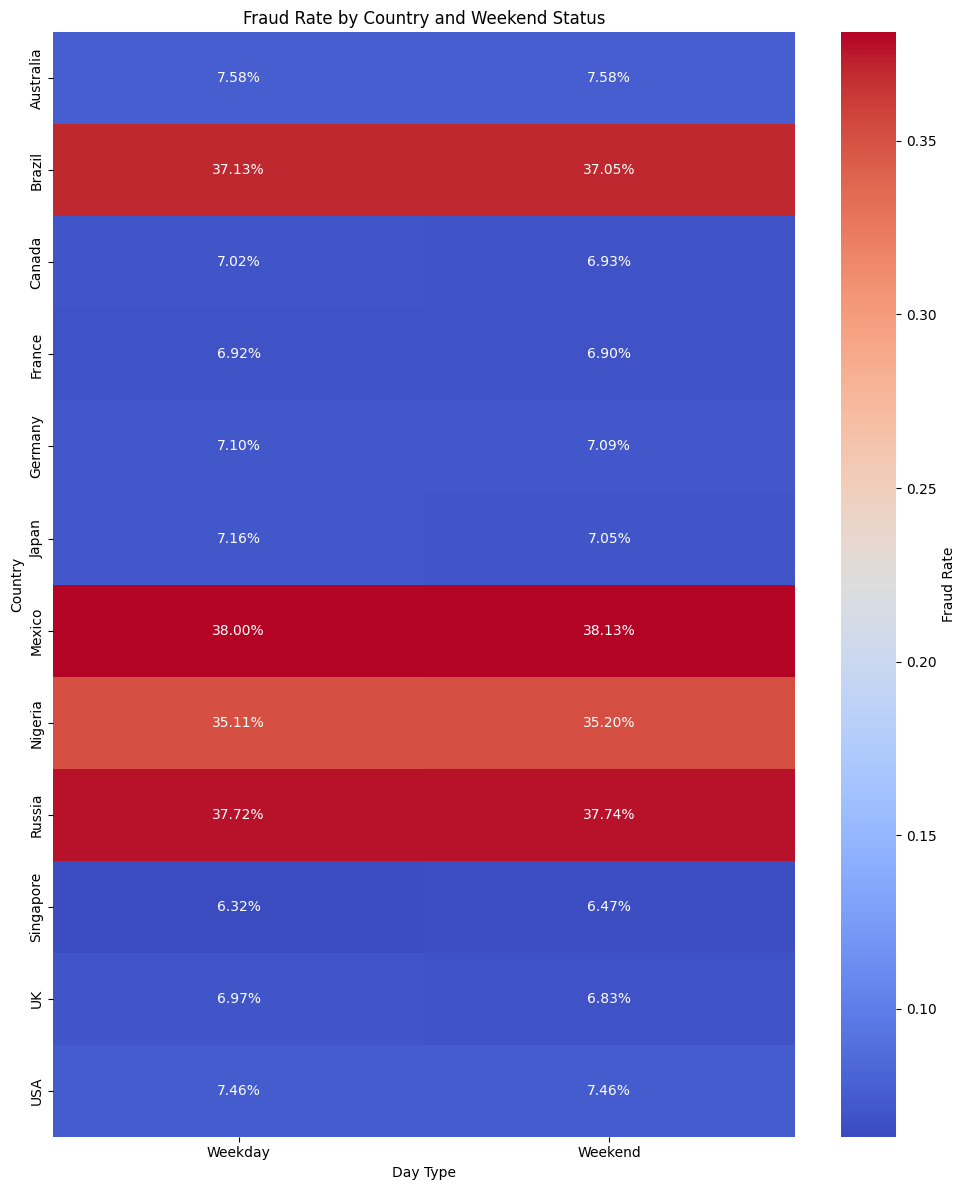

In [52]:
weekend_countries = (
    df
    .filter(pl.col("country").is_not_null())
    .group_by(["country", "is_weekend"])
    .agg([
        pl.count().alias("total"),
        pl.col("is_fraud").sum().alias("frauds")
    ])
    .with_columns([
        (pl.col("frauds") / pl.col("total")).alias("fraud_rate")
    ])
    .sort("fraud_rate", descending=True)
    .to_pandas()
)

pivot = weekend_countries.pivot(index="country", columns="is_weekend", values="fraud_rate")
pivot.columns = ["Weekday", "Weekend"]  # False -> Weekday, True -> Weekend

plt.figure(figsize=(10, 12))
sns.heatmap(pivot, annot=True, fmt=".2%", cmap="coolwarm", cbar_kws={"label": "Fraud Rate"})
plt.title("Fraud Rate by Country and Weekend Status")
plt.ylabel("Country")
plt.xlabel("Day Type")
plt.tight_layout()
plt.show()


# 3: Каналы по странам

# Страны и каналы

/tmp/ipykernel_381129/1282101859.py:6: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

/tmp/ipykernel_381129/1282101859.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




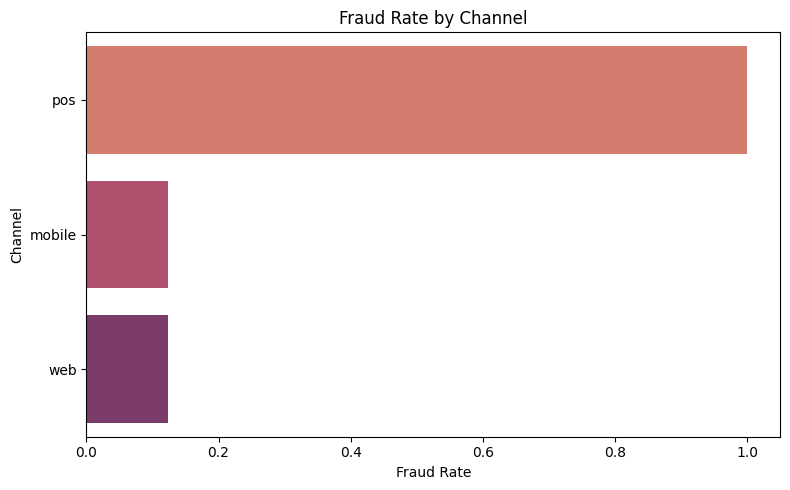

In [64]:
channel_stats = (
    df
    .filter(pl.col("channel").is_not_null())
    .group_by("channel")
    .agg([
        pl.count().alias("total_tx"),
        pl.col("is_fraud").sum().alias("fraud_count")
    ])
    .with_columns([
        (pl.col("fraud_count") / pl.col("total_tx")).alias("fraud_rate")
    ])
    .sort("fraud_rate", descending=True)
    .to_pandas()
)


plt.figure(figsize=(8, 5))
sns.barplot(
    data=channel_stats.sort_values("fraud_rate", ascending=False),
    x="fraud_rate", y="channel", palette="flare"
)
plt.xlabel("Fraud Rate")
plt.ylabel("Channel")
plt.title("Fraud Rate by Channel")
plt.tight_layout()
plt.show()


/tmp/ipykernel_381129/4000578197.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




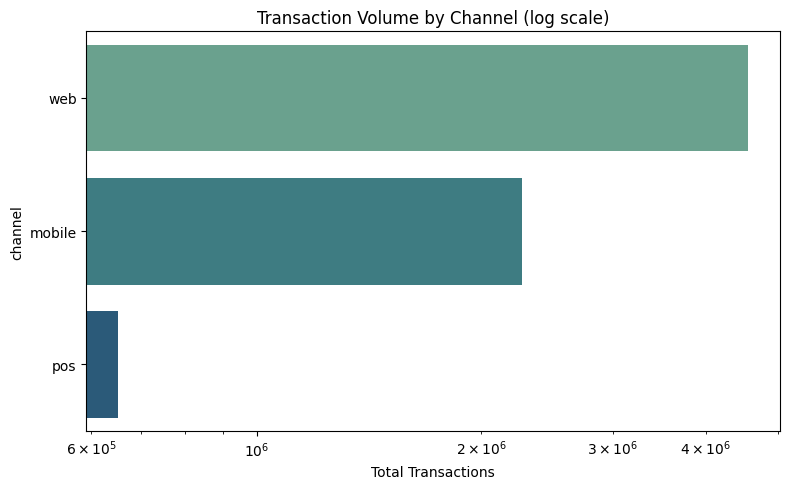

In [66]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=channel_stats.sort_values("total_tx", ascending=False),
    x="total_tx", y="channel", palette="crest"
)
plt.xlabel("Total Transactions")
plt.xscale("log")  # потому что разница может быть в разы
plt.title("Transaction Volume by Channel (log scale)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_381129/31271195.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




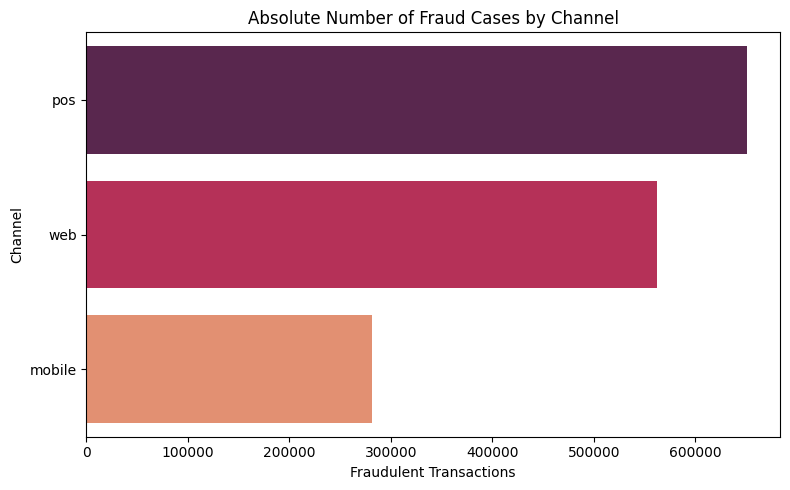

In [68]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=channel_stats.sort_values("fraud_count", ascending=False),
    x="fraud_count", y="channel", palette="rocket"
)
plt.xlabel("Fraudulent Transactions")
plt.ylabel("Channel")
plt.title("Absolute Number of Fraud Cases by Channel")
plt.tight_layout()
plt.show()


## Теперь онлайн

/tmp/ipykernel_381129/1650174787.py:10: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



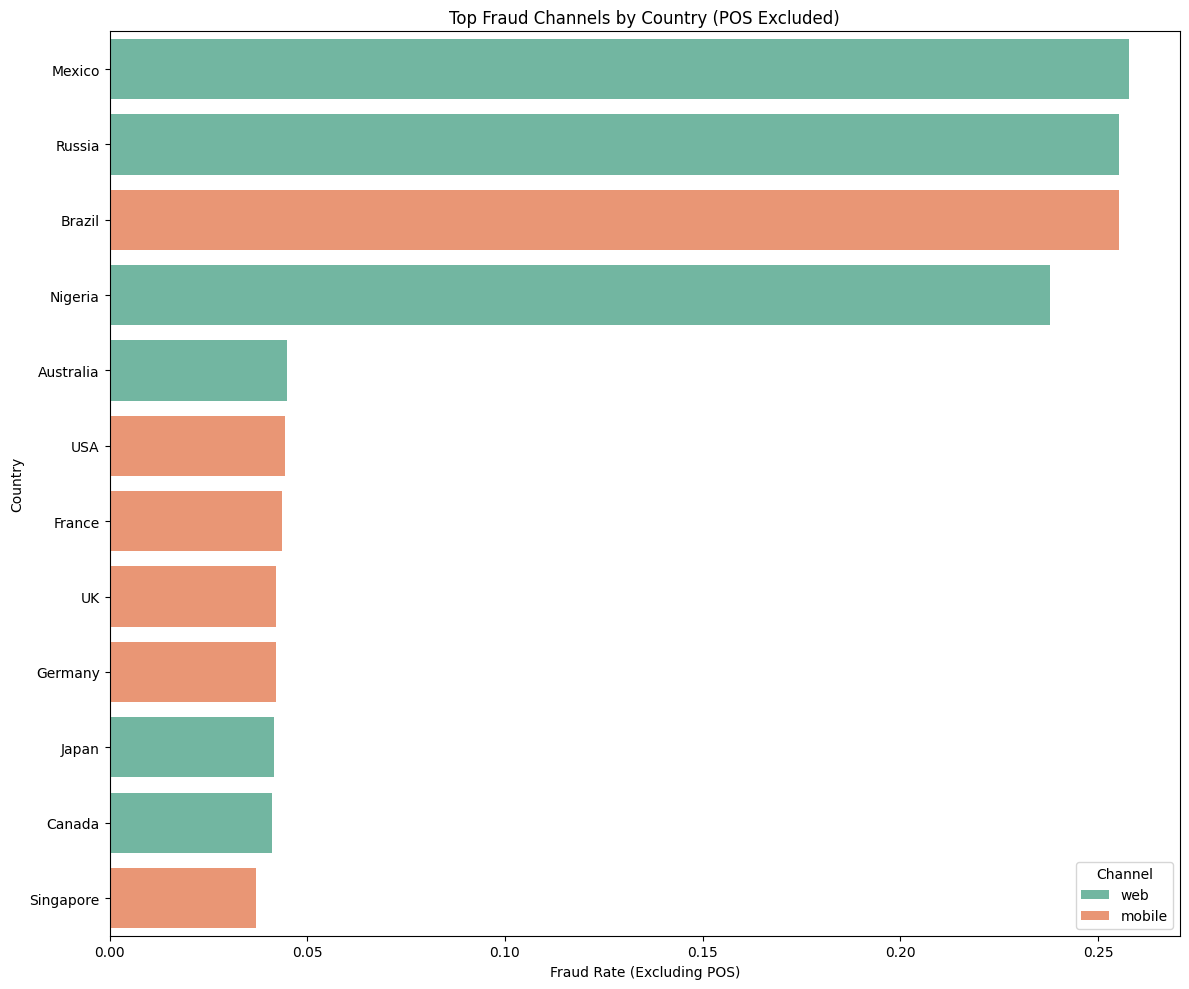

In [58]:
fraud_by_country_channel_no_pos = (
    df
    .filter(
        pl.col("country").is_not_null() &
        pl.col("channel").is_not_null() &
        (pl.col("channel") != "pos")
    )
    .group_by(["country", "channel"])
    .agg([
        pl.count().alias("total"),
        pl.col("is_fraud").sum().alias("frauds")
    ])
    .with_columns([
        (pl.col("frauds") / pl.col("total")).alias("fraud_rate")
    ])
)
max_online_fraud_channel_by_country = (
    fraud_by_country_channel_no_pos
    .sort(["country", "fraud_rate"], descending=[False, True])
    .group_by("country")
    .agg([
        pl.col("channel").first().alias("worst_channel"),
        pl.col("fraud_rate").first().alias("fraud_rate")
    ])
    .sort("fraud_rate", descending=True)
    .to_pandas()
)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=max_online_fraud_channel_by_country.head(20),  # ТОП-20 стран по риску
    y="country",
    x="fraud_rate",
    hue="worst_channel",
    dodge=False,
    palette="Set2"
)
plt.xlabel("Fraud Rate (Excluding POS)")
plt.ylabel("Country")
plt.title("Top Fraud Channels by Country (POS Excluded)")
plt.legend(title="Channel", loc="lower right")
plt.tight_layout()
plt.show()


# В доллары

In [2]:
df_tx = pl.read_parquet("transaction_fraud_data.parquet")
df_fx = pl.read_parquet("historical_currency_exchange.parquet")

df_tx = df_tx.with_columns([
    pl.col("timestamp").dt.date().alias("tx_date")
])

df_fx_long = df_fx.melt(
    id_vars="date",
    variable_name="currency",
    value_name="rate_to_usd"
)

df_joined = df_tx.join(
    df_fx_long,
    left_on=["tx_date", "currency"],
    right_on=["date", "currency"],
    how="left"
)

df_joined = df_joined.with_columns([
    (pl.col("amount") / pl.col("rate_to_usd")).alias("amount_usd")
])

df_joined.select([
    "timestamp", "currency", "amount", "rate_to_usd", "amount_usd"
]).filter(pl.col("currency") != "USD").sample(5)


/tmp/ipykernel_389860/2749943922.py:8: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  df_fx_long = df_fx.melt(


timestamp,currency,amount,rate_to_usd,amount_usd
datetime[μs],str,f64,f64,f64
2024-10-06 05:09:55.307366,"""GBP""",78.13,0.762157,102.511629
2024-10-21 07:23:44.558629,"""SGD""",652.83,1.309439,498.55697
2024-10-18 07:44:42.135989,"""MXN""",89.11,19.819733,4.496024
2024-10-05 04:12:34.516568,"""NGN""",1.4198e6,1619.465727,876.723475
2024-10-03 11:50:17.771865,"""SGD""",435.37,1.294391,336.351182


# Топ фроды

In [3]:
df_joined\
.filter(pl.col("is_fraud") & pl.col("amount_usd").is_not_null())\
.sort("amount_usd", descending=True)\
.select([
    "timestamp", "customer_id", "country", "city", "channel", "device",
    "vendor_category", "amount", "currency", "amount_usd"
])\
.head(20)


timestamp,customer_id,country,city,channel,device,vendor_category,amount,currency,amount_usd
datetime[μs],str,str,str,str,str,str,f64,str,f64
2024-10-12 04:10:11.069878,"""CUST_84744""","""Mexico""","""Unknown City""","""web""","""Firefox""","""Travel""",304393.59,"""MXN""",15781.540993
2024-10-07 04:45:46.947073,"""CUST_61661""","""Mexico""","""Unknown City""","""mobile""","""Android App""","""Travel""",303546.23,"""MXN""",15757.587128
2024-10-08 02:47:55.592891,"""CUST_91532""","""Mexico""","""Unknown City""","""pos""","""NFC Payment""","""Travel""",303356.28,"""MXN""",15720.07849
2024-09-30 20:19:33.790011,"""CUST_58337""","""Singapore""","""Unknown City""","""web""","""Safari""","""Travel""",20090.47,"""SGD""",15693.767745
2024-10-14 02:55:43.645247,"""CUST_52188""","""Singapore""","""Unknown City""","""pos""","""Magnetic Stripe""","""Travel""",20475.8,"""SGD""",15682.188327
…,…,…,…,…,…,…,…,…,…
2024-10-13 02:42:05.988032,"""CUST_78020""","""Mexico""","""Unknown City""","""web""","""Firefox""","""Travel""",299659.98,"""MXN""",15544.818154
2024-10-06 23:37:00.926217,"""CUST_89677""","""Mexico""","""Unknown City""","""pos""","""NFC Payment""","""Travel""",299383.4,"""MXN""",15524.332197
2024-10-06 01:04:17.372726,"""CUST_27238""","""Singapore""","""Unknown City""","""pos""","""NFC Payment""","""Travel""",20245.47,"""SGD""",15519.227056


In [4]:
import polars as pl
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# Фильтрация данных и логарифмирование суммы
df_clust = (
    df_joined
    .filter(pl.col("amount_usd").is_not_null() & pl.col("device").is_not_null())
    .with_columns([
        pl.col("amount_usd").log1p().alias("amount_usd_log")
    ])
)

# One-Hot для device
devices = df_clust.select("device").to_series().to_list()
ohe = OneHotEncoder(sparse_output=False)
device_ohe = ohe.fit_transform(np.array(devices).reshape(-1, 1))

# Признаки для кластеризации
X = np.hstack([df_clust.select("amount_usd_log").to_numpy(), device_ohe])

# Кластеризация
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Добавляем результат кластеризации в DataFrame
df_clust = df_clust.with_columns(pl.Series("cluster", labels))

# Метрики по кластерам
cluster_stats = (
    df_clust.group_by("cluster")
    .agg([
        pl.count().alias("n_tx"),
        pl.col("amount_usd").sum().alias("sum_usd"),
        pl.col("amount_usd").mean().alias("mean_usd"),
        pl.col("is_fraud").mean().alias("fraud_rate")
    ])
    .sort("cluster")
)
cluster_stats

/tmp/ipykernel_389860/1333971348.py:34: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_tx"),


cluster,n_tx,sum_usd,mean_usd,fraud_rate
i32,u32,f64,f64,f64
0,1565791,2.3501e9,1500.884895,0.382467
1,1464736,1.5065e8,102.851698,0.090287
2,3213281,1.2411e9,386.244583,0.083267
3,461528,1.0132e6,2.195419,0.97944
4,778430,3.1810e8,408.646533,0.056537


In [5]:
# ТОП-5 стран по каждой группе
top_countries = (
    df_clust.group_by(["cluster", "country"])
    .agg(pl.count().alias("count"))
    .sort(["cluster", "count"], descending=[False, True])
    .group_by("cluster")
    .agg([
        pl.col("country").head(5).alias("top_countries"),
        pl.col("count").head(5).alias("top_counts")
    ])
    .sort("cluster")
)

top_countries


/tmp/ipykernel_389860/2685577374.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


cluster,top_countries,top_counts
i32,list[str],list[u32]
0,"[""Mexico"", ""Brazil"", … ""Germany""]","[248091, 232774, … 112305]"
1,"[""Nigeria"", ""Russia"", … ""Canada""]","[468928, 127041, … 88380]"
2,"[""Brazil"", ""Russia"", … ""France""]","[306486, 297748, … 270994]"
3,"[""Nigeria"", ""Mexico"", … ""Australia""]","[101922, 90084, … 11387]"
4,"[""Canada"", ""Russia"", … ""Mexico""]","[78684, 75182, … 69460]"
